# Principal Component Analysis (PCA) for Feature Extraction

PCA can also be used for feature extraction.

THe idea behind feature extraction is that PCA can find a better representation of data than the raw features.

A good application is with image data, where the raw features are the pixel values of the image. Objects in images are usually made up of a combination of pixels, and only together are they meaningful.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import mglearn

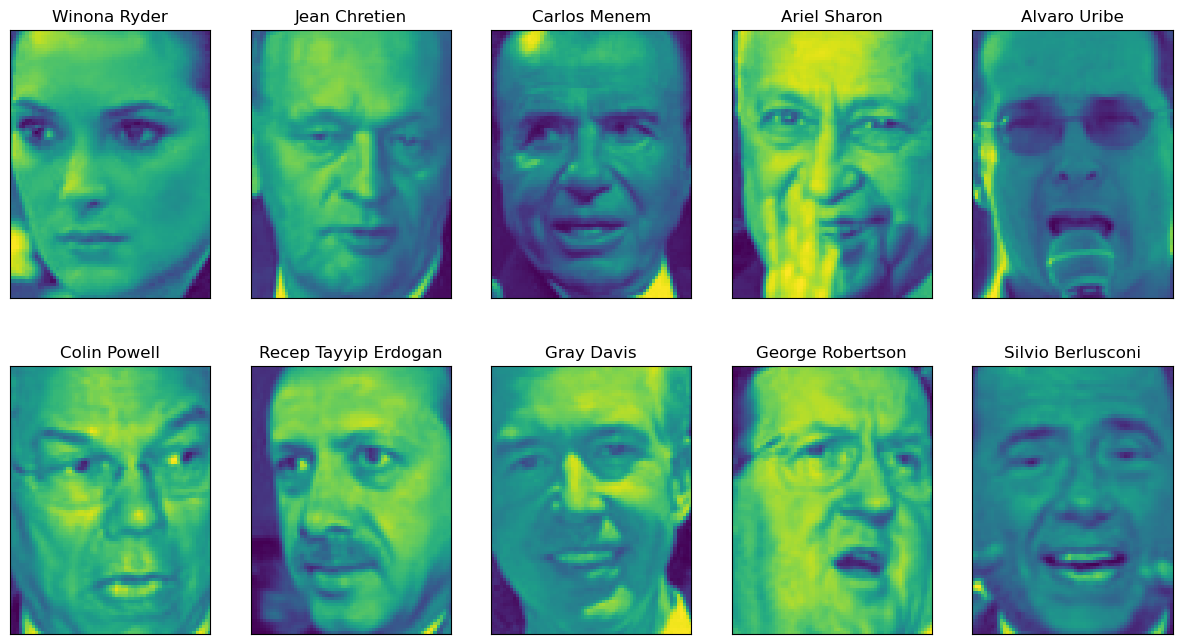

In [27]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fig, anes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, anes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [28]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


In [29]:
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names:
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

In [30]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

A common task in face recognition is to ask if a previously unseen face belongs to a known person from a database.

- There are usually many different people in the database, so the number of classes is large.
- And very few images of each person, so the number of examples per class is small.
-> Hard to train a classifier.

A simple way to solve this is to use a one-nearest-neighbour classifier, which is a simple and powerful classifier.

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

# build a KNeighborsClassifier using one neighbor
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.22


Considering that the number of classes is 62, it is not that bad score (Random guessing would give 1/62 = 1.5% accuracy), but it is not great either.

Computing distances in the original pixel space is a bad way to measure similarity between faces.
- Hard to capture the facial features.
- Shifting a face by one pixel to the right changes all pixel values and makes the face completely unrecognizable.

PCA can help to find a more suitable representation for the face images.

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


In [33]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.30


- The accuracy is slightly better.

For image data, we can also visualize the principal components as images.

In [34]:
print("pca.components_.shape: {}".format(pca.components_.shape))

pca.components_.shape: (100, 5655)


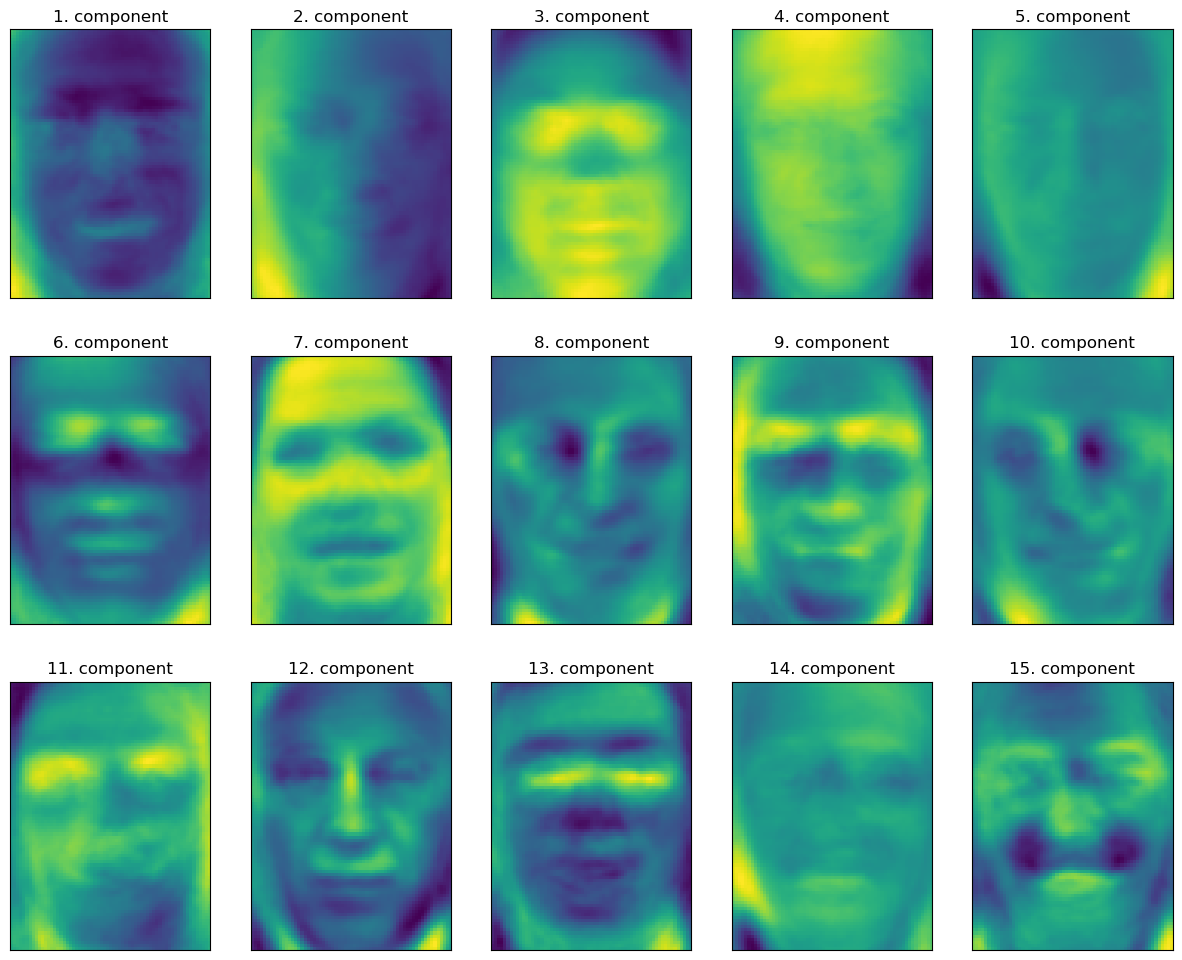

In [35]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))

We can guess what the principal components represent, but it is hard to interpret them.
- The first principal component seems to represent the contrast between the face and the background.
- The second principal component seems to represent the lighting direction.

While this representation is slightly more semantically meaningful, but it is still far from how a human would interpret the images.

PCA is a purely mathematical technique that does not take into account the semantics of the data.

Algorithms often interpret data quite differently from humans.

Another way to interpret the principal components is to look at the reconstruction of the original data from only the first few principal components.

The reconstruction is not perfect, but it captures the most important aspects of the data.

In [40]:
def pca_faces(X_train, X_test):
    # copy and pasted from nmf. refactor?
    # Build NMF models with 10, 50, 100, 500 components
    # this list will hold the back-transformd test-data
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        # build the NMF model
        pca = PCA(n_components=n_components)
        pca.fit(X_train)
        # transform the test data (afterwards has n_components many dimensions)
        X_test_pca = pca.transform(X_test)
        # back-transform the transformed test-data
        # (afterwards it's in the original space again)
        X_test_back = pca.inverse_transform(X_test_pca)
        reduced_images.append(X_test_back)
    return reduced_images


def plot_pca_faces(X_train, X_test, image_shape):
    reduced_images = pca_faces(X_train, X_test)

    # plot the first three images in the test set:
    fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for i, ax in enumerate(axes):
        # plot original image
        ax[0].imshow(X_test[i].reshape(image_shape))
        # plot the four back-transformed images
        for a, X_test_back in zip(ax[1:], reduced_images):
            a.imshow(X_test_back[i].reshape(image_shape))

    # label the top row
    axes[0, 0].set_title("original image")
    for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500]):
        ax.set_title("%d components" % n_components)

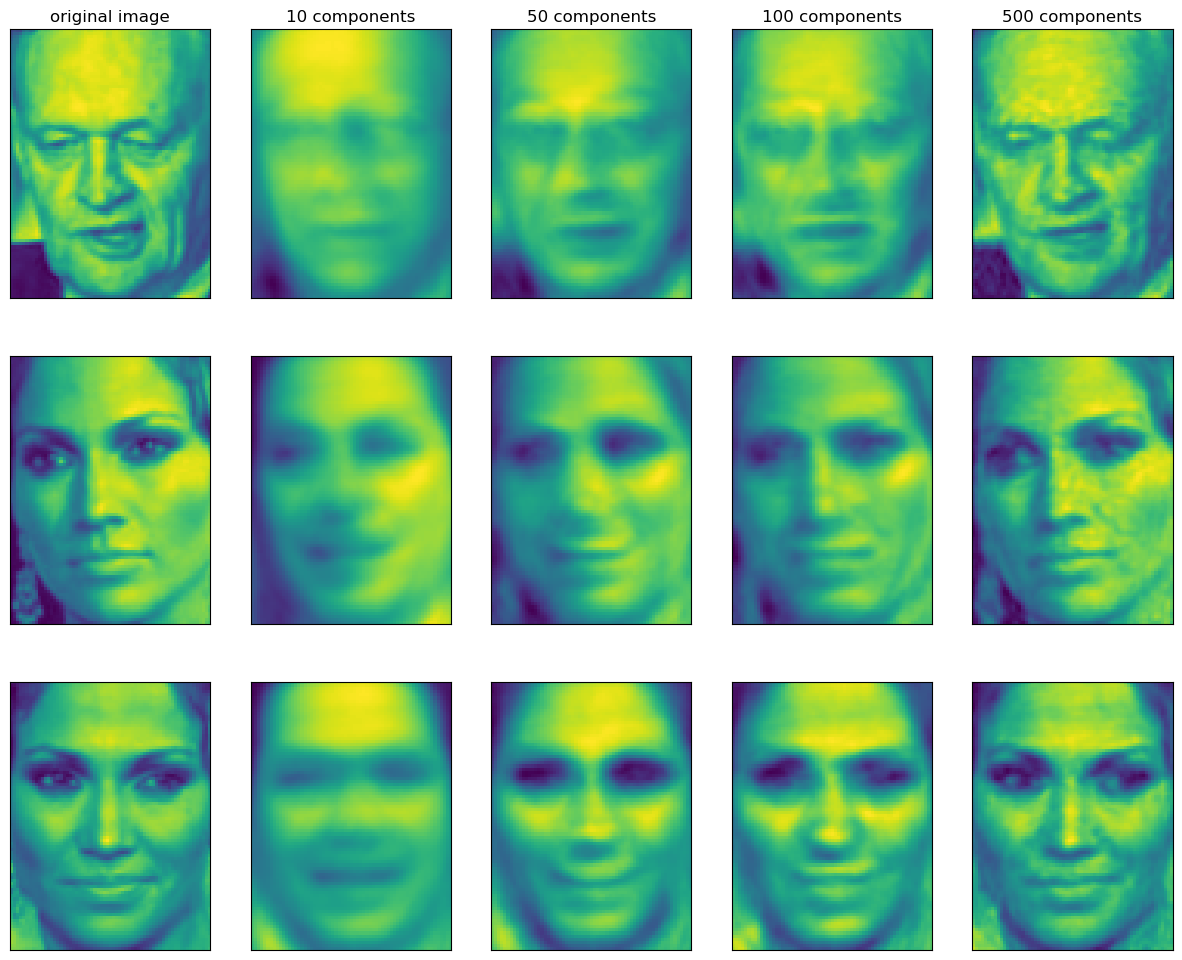

In [41]:
plot_pca_faces(X_train, X_test, image_shape)

Text(0, 0.5, 'Second principal component')

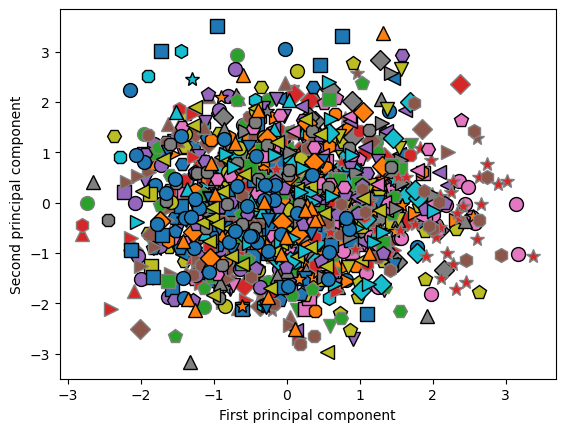

In [42]:
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

Scatter plot using the first two principal components.